In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


In [4]:
#######
DATA_FNAME = '/data/delon/LensQuEst/N0_Ni.pkl'
kTkT_DATA_FNAME =  '/data/delon/LensQuEst/kk_masked_true.pkl'

mean_field_file = 'mask_simple400x400_point_sources_bigger.pkl'
import warnings
warnings.filterwarnings("ignore")
#####

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 400 # 1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [7]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [9]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [10]:
f = open(DATA_FNAME, 'rb') 
data = pickle.load(f) 
f.close()

for key in data:
    print(key, np.shape(data[key]))

k1_1 (100, 400, 201)
sqrtNhat1_1 (100, 400, 201)
kR1_1 (100, 400, 201)
Nhat1_1 (100, 3, 50)
kRkR1_1 (100, 3, 50)
kk1_1 (100, 3, 50)
k1_0 (100, 400, 201)
sqrtNhat1_0 (100, 400, 201)
kR1_0 (100, 400, 201)
Nhat1_0 (100, 3, 50)
kRkR1_0 (100, 3, 50)
kk1_0 (100, 3, 50)
k0_1 (100, 400, 201)
sqrtNhat0_1 (100, 400, 201)
kR0_1 (100, 400, 201)
Nhat0_1 (100, 3, 50)
kRkR0_1 (100, 3, 50)
kk0_1 (100, 3, 50)
k0_0 (100, 400, 201)
sqrtNhat0_0 (100, 400, 201)
kR0_0 (100, 400, 201)
Nhat0_0 (100, 3, 50)
kRkR0_0 (100, 3, 50)
kk0_0 (100, 3, 50)


In [11]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


# In[10]:


from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread('mask_simple%dx%d.png'%(nX, nY)))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread('point_sources_bigger.png'))
point_sources = gaussian_filter(point_sources, 1.5) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)
fsky = np.sum(apodized_mask)/(nX*nY)
c1 = fsky
c2 = fsky**2

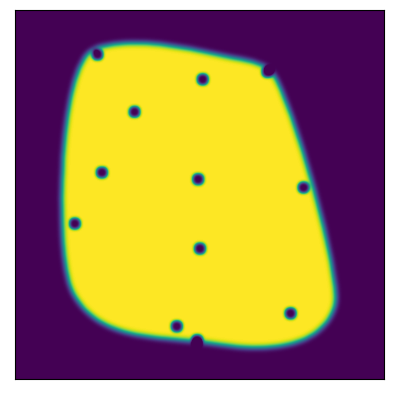

In [79]:
plt.imshow(apodized_mask)
plt.xticks([])
plt.yticks([])
plt.savefig('figures/mask.png', bbox_inches='tight')

In [12]:
sns.cubehelix_palette(start=26/10, light=.97, n_colors=5, gamma=3)

[[0.972562387775395, 0.893490378172129, 0.9178096117912778],
 [0.5961309084991482, 0.3544338716240667, 0.5384173512090582],
 [0.22513275114875114, 0.1335788491633064, 0.27276075825535656],
 [0.042945957908899574, 0.03830631700325862, 0.07709542255701261],
 [0.0020828626167409964, 0.003498693978883299, 0.005637882351707143]]

In [13]:
cmap = [sns.cubehelix_palette(start=26/10, light=.97, n_colors=5), 
        sns.cubehelix_palette(start=17/10, light=.97, n_colors=5)]



plotting data
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


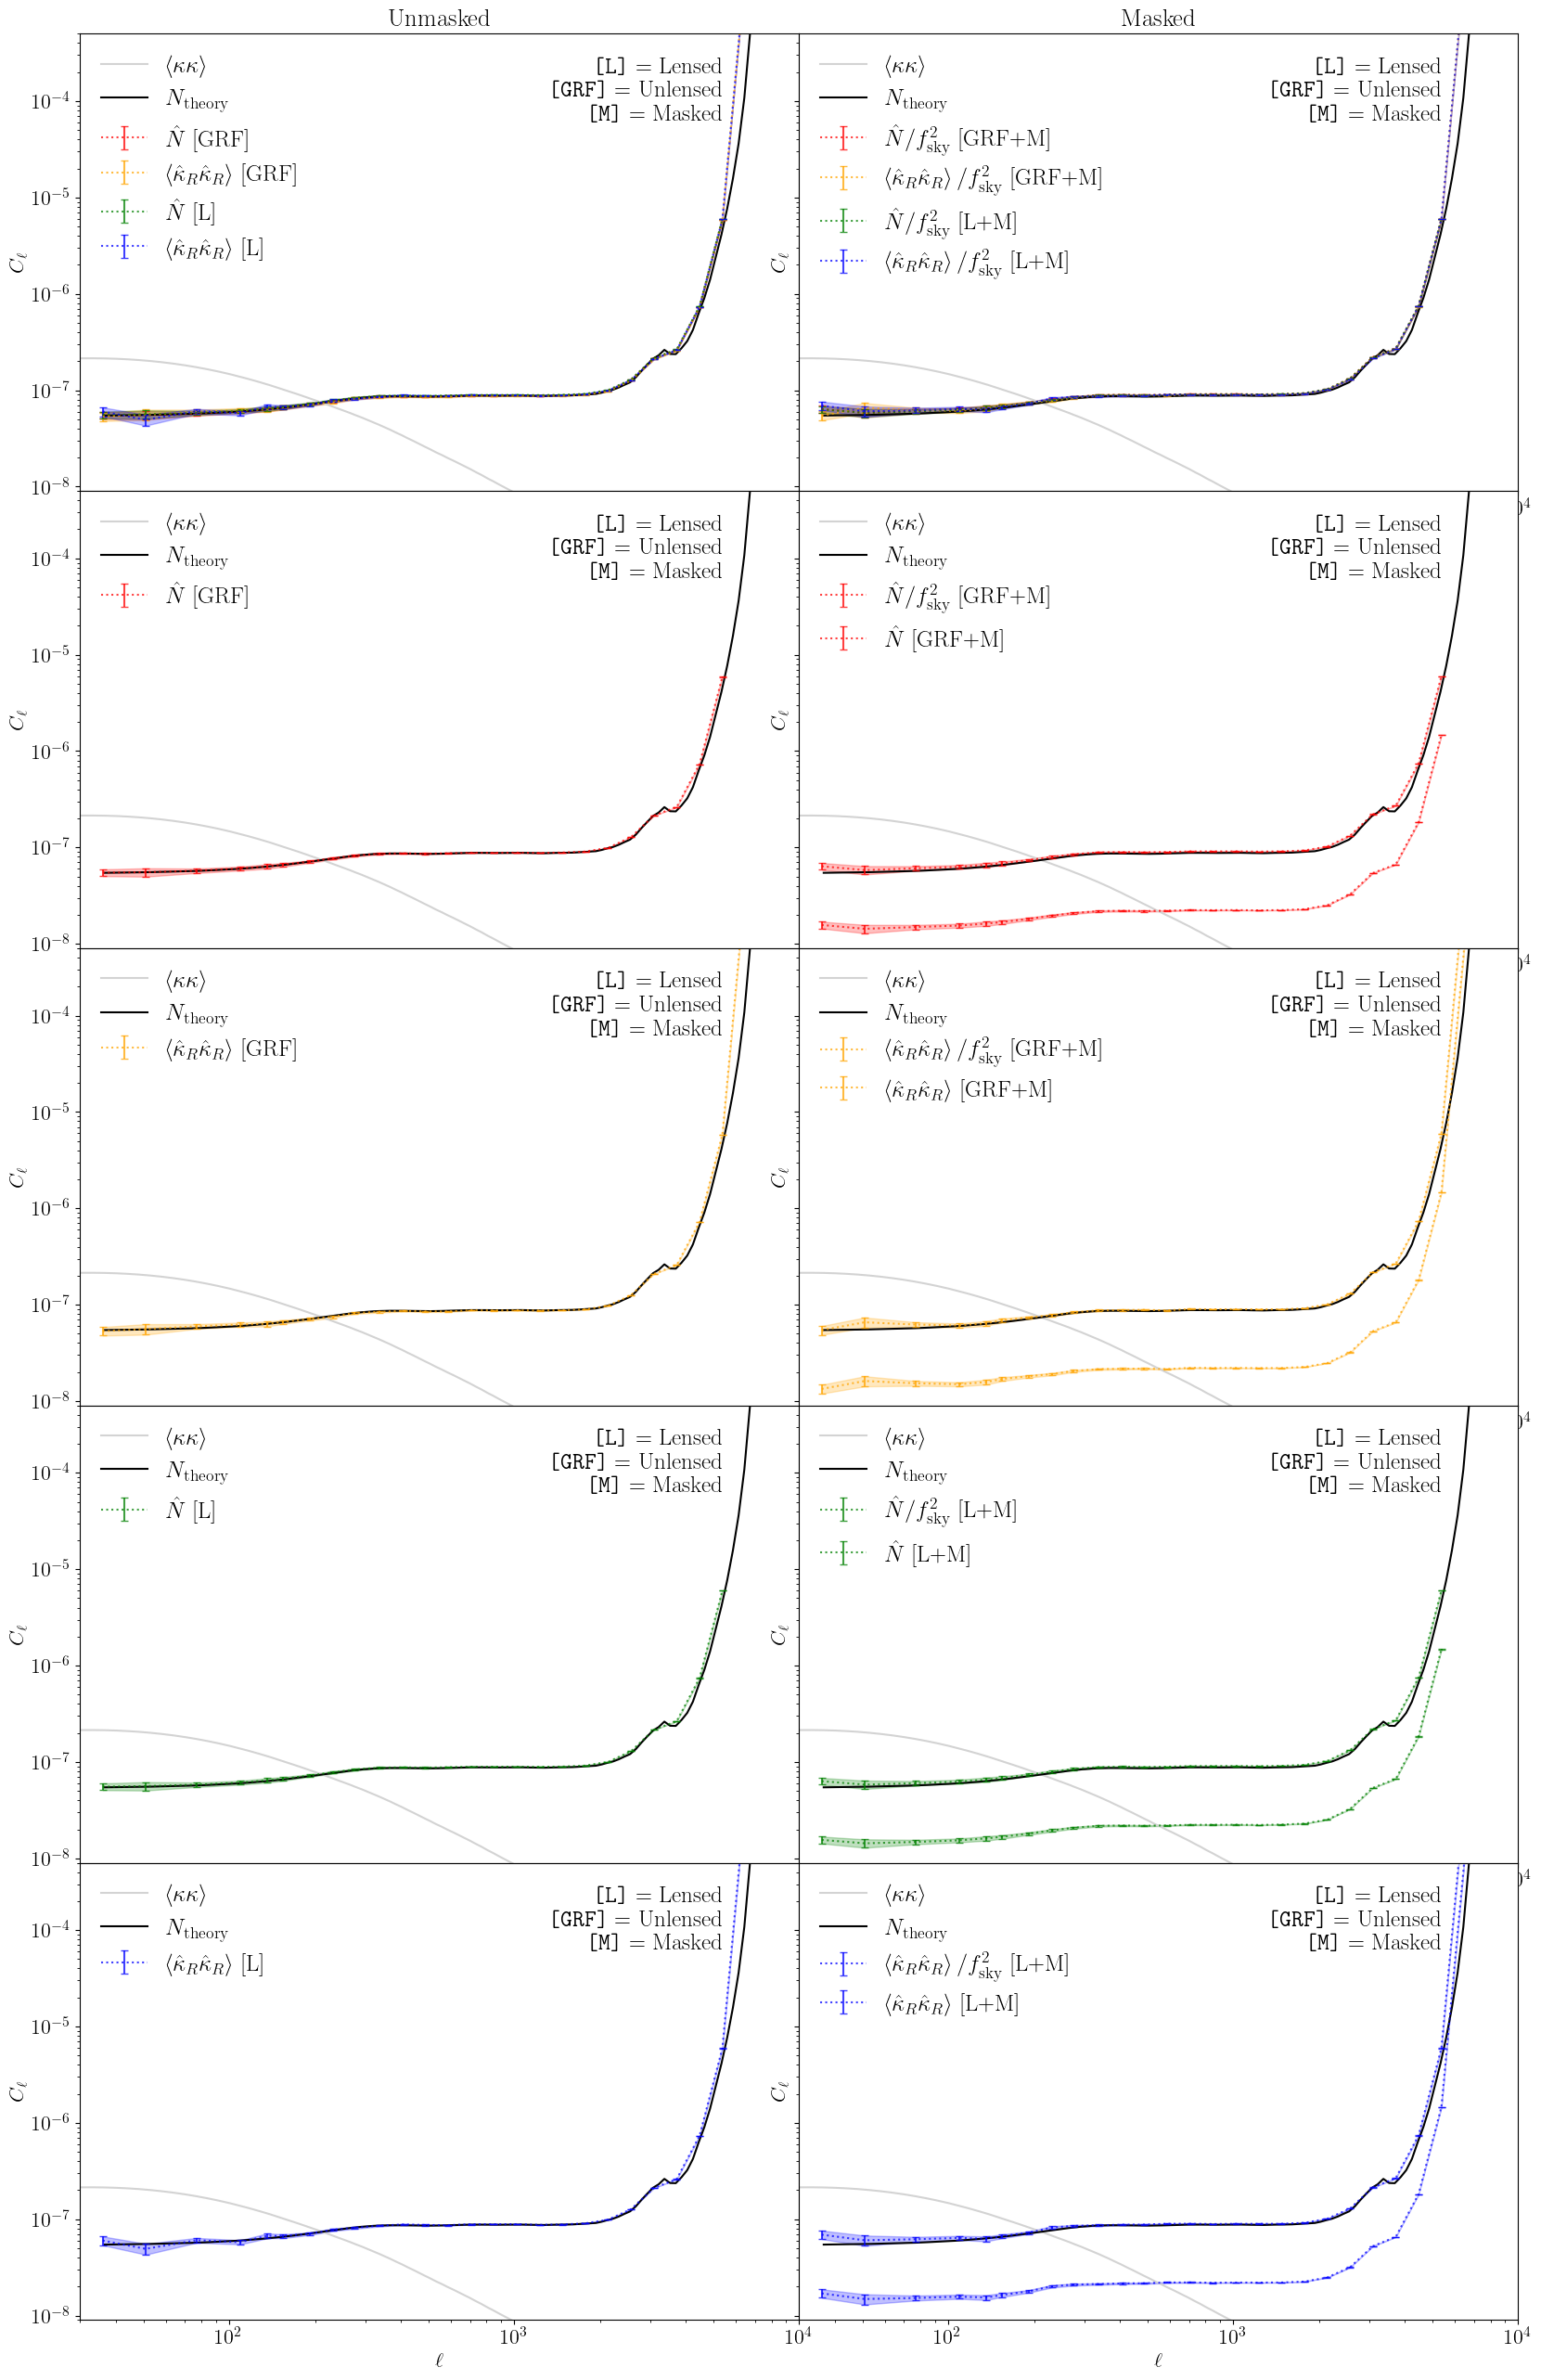

In [31]:
#Look at N0 Biases
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20,32), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
ell = baseMap.l.flatten()

Ntheory = lambda l: fNqCmb_fft(l) #+ fNqCmbFG_fft(l)
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=[ 'lightgrey','black']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax in axs.flatten():
        ax.plot(L, ClExpected, sty, label=l)


c_keys = [
    'Nhat0_0',
    'kRkR0_0',
    'Nhat0_1',
    'kRkR0_1',
    'Nhat1_0',
    'kRkR1_0',
    'Nhat1_1',
    'kRkR1_1',
]

col = dict(zip(c_keys, [
    'r',
    'orange',
    'g',
    'b',
    'r',
    'orange',
    'g',
    'b',

]))

labels = dict(zip(c_keys, [
    r'$\hat N$ [GRF]',
    r'$\left<\hat\kappa_R\hat\kappa_R\right>$ [GRF]',
    r'$\hat N$ [L]',
    r'$\left<\hat\kappa_R\hat\kappa_R\right>$ [L]',
    r'$\hat N/f_{\rm sky}^2$ [GRF+M]',
    r'$\left<\hat\kappa_R\hat\kappa_R\right>/f_{\rm sky}^2$ [GRF+M]',
    r'$\hat N/f_{\rm sky}^2$ [L+M]',
    r'$\left<\hat\kappa_R\hat\kappa_R\right>/f_{\rm sky}^2$ [L+M]',
]))
aux_labels = dict(zip(c_keys, [
    r'$\hat N$ [GRF]',
    r'$\left<\hat\kappa_R\hat\kappa_R\right>$ [GRF]',
    r'$\hat N$ [L]',
    r'$\left<\hat\kappa_R\hat\kappa_R\right>$ [L]',
    r'$\hat N$ [GRF+M]',
    r'$\left<\hat\kappa_R\hat\kappa_R\right>$ [GRF+M]',
    r'$\hat N$ [L+M]',
    r'$\left<\hat\kappa_R\hat\kappa_R\right>$ [L+M]',
]))
idxs = dict(zip(c_keys,
               [
                    [[0, 0] ,[0, 1]],
                    [[0, 0], [0, 2]],
                    [[0, 0], [0, 3]],
                    [[0, 0], [0, 4]],
                    [[1, 0] ,[1, 1]],
                    [[1, 0], [1, 2]],
                    [[1, 0], [1, 3]],
                    [[1, 0], [1, 4]],               
               ]))
print('plotting data')


off = 0.00
offsets = dict(zip(c_keys, [-off,0,off,2*off,-off,0,off,2*off ]))


def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(data[key]))
    
    
    Ipos = np.where(Cl>=1e-10)

    for idx in idxs[key]:
            
        ax = axs[idx[1]][idx[0]]
        
        
        offset = offsets[key]
        tmp = np.zeros_like(lCen)
        if(idx[1] == 0):
            tmp = np.array([l*np.exp(offset)-l for l in lCen])


        ax.errorbar(lCen[Ipos]+tmp[Ipos], (Cl[Ipos]), 
                    yerr=sCl[Ipos], c=col[key], 
                    alpha=.75, fmt=':', 
                    capsize=3, label=labels[key], capthick=1)

        tmp_data = {
           'x': lCen[Ipos]+tmp[Ipos],
           'y1': [y - e for y, e in zip(Cl[Ipos], sCl[Ipos])],
           'y2': [y + e for y, e in zip(Cl[Ipos], sCl[Ipos])]}
        ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    
        if(idx[1]!=0 and idx[0]==1):
            ax.errorbar(lCen[Ipos], fsky**2*(Cl[Ipos]), 
            yerr=fsky**2*sCl[Ipos], c=col[key], 
            alpha=.75, fmt=':', 
            capsize=3, label=aux_labels[key], capthick=1)

            tmp_data = {
               'x': lCen[Ipos],
               'y1': [y - e for y, e in zip(fsky**2*Cl[Ipos], fsky**2*sCl[Ipos])],
               'y2': [y + e for y, e in zip(fsky**2*Cl[Ipos], fsky**2*sCl[Ipos])]}
            ax.fill_between(**tmp_data, color=col[key], alpha=.25)



for ax in axs.flatten():
    l=ax.legend(frameon=False, loc='upper left')
    s = r'\texttt{[L]} = Lensed'
    s += '\n'
    s += r'\texttt{[GRF]} = Unlensed'
    s += '\n'
    s += r'\texttt{[M]} = Masked'

    ax.text(.90, .95,
       s=s,
       transform=ax.transAxes,
       horizontalalignment='right',
       verticalalignment='top',
      fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$C_\ell$')
    ax.set_ylim(.9e-8,.5e-3)
    ax.set_xlim(30,1e4)


cols = ['Unmasked', 'Masked']
for ax, col in zip(axs[0], cols):
    ax.set_title(col)
    
plt.savefig( 
'figures/N0_comp.pdf',
    bbox_inches='tight'
)
plt.savefig( 
'figures/N0_comp.png',
    bbox_inches='tight'
)

In [273]:
def corr(corr_nhat, label, cmap, filename_base, ll = ['%d'%l for l in data['kk0_0'][0][0]]):

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 16

    plt.figure(figsize=(25,20))
    ax = sns.heatmap(corr_nhat, cmap=cmap, cbar=True, vmin=0, vmax=1, square=True,
                    cbar_kws={'label': r"$|\rho|$", 
                              "orientation": "horizontal", 'pad':0.1, 'shrink':0.3})

    ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
    ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
    plt.xlabel(r'$\ell$'+'\n')



    ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
    ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
    plt.ylabel(r'$\ell$'+'\n')

    plt.title(r'Correlation for %s'%(label))
    plt.xlim(19, 43)
    plt.ylim(19, 43)

    plt.savefig('figures/corr_%s.pdf'%(filename_base), bbox_inches='tight')
    plt.savefig('figures/corr_%s.png'%(filename_base), bbox_inches='tight')


def corr_and_sub(key_kk, key_sub, cmap, label, filename_base, theory=False):

    Cls_tmp = np.transpose(np.copy(data[key_kk]), axes=[1,2,0])
    ls = data[key_kk][0][0]
    ll = ['%d'%l for l in ls]

    if(theory):
        Cls_tmp[1] -= np.transpose([[Ntheory(l) for l in ls] for _ in range(len(data[key_kk]))])
    else:
        Cls_tmp[1] -= np.transpose(data[key_sub], axes=[1,2,0])[1]
    
    corr_nhat = np.array([[np.abs(np.corrcoef(Cls_tmp[1][i1], Cls_tmp[1][i2])[1,0])
                          for i1 in range(len(Cls_tmp[1]))]
                         for i2 in range(len(Cls_tmp[1]))])


    corr(corr_nhat, label, cmap, filename_base, ll)
    fig, axs = plt.subplots(nrows=1, figsize=(12,6), sharey=True)
    ax = axs


    theory=[p2d_cmblens.fPinterp, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
        L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
        ClExpected = np.array(list(map(f, L)))

        ax.plot(L, ClExpected, sty, label=l)



    Cls_tmp =  np.transpose(Cls_tmp, axes=[2,0,1])
    lCen, Cl, sCl = combine_Cl(Cls_tmp)


    ax.errorbar(lCen[Ipos], (Cl[Ipos]), 
                yerr=sCl[Ipos], 
                alpha=.75, fmt=':', 
                capsize=3, capthick=1,
               label=label,
                c=cmap[2]
               )

    tmp_data = {
       'x': lCen[Ipos],
       'y1': [y - e for y, e in zip(Cl[Ipos], sCl[Ipos])],
       'y2': [y + e for y, e in zip(Cl[Ipos], sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25, color=cmap[2])
    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(3e-10, .5e-4)
    ax.set_xlim(30,1e4)
    

    plt.savefig('figures/Cl_%s.pdf'%(filename_base), bbox_inches='tight')
    plt.savefig('figures/Cl_%s.png'%(filename_base), bbox_inches='tight')

    return fig, ax



100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


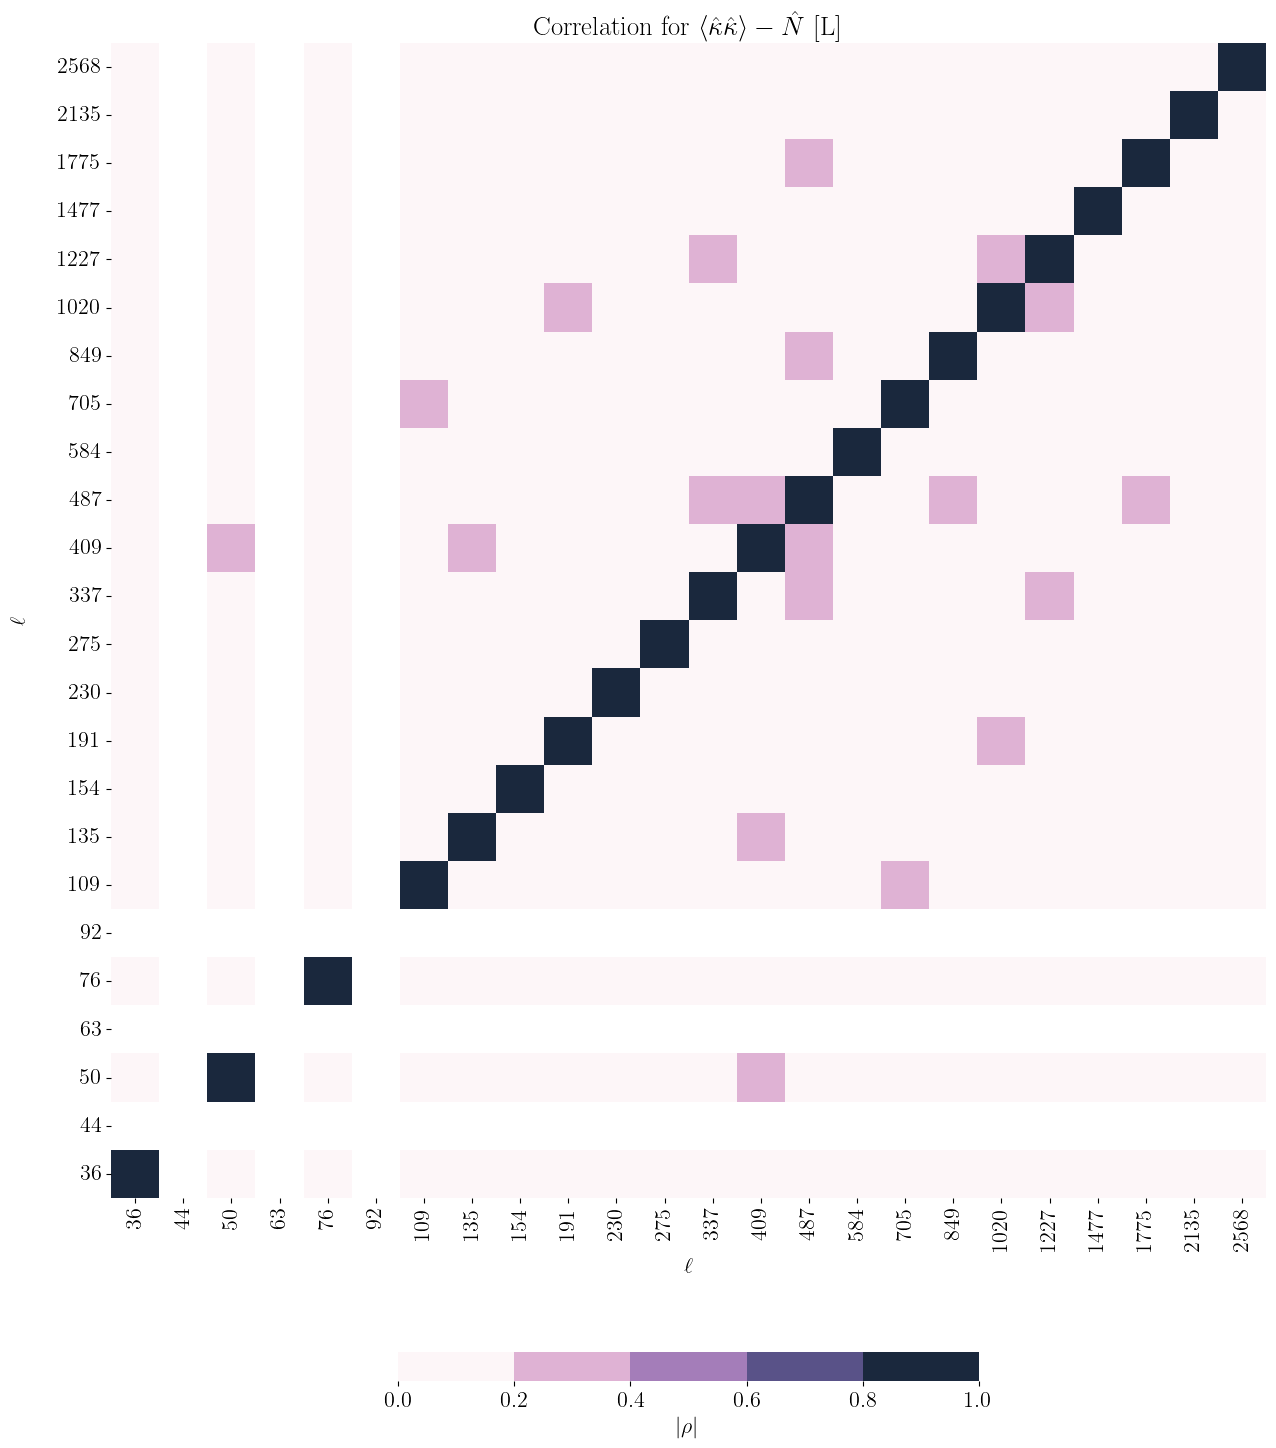

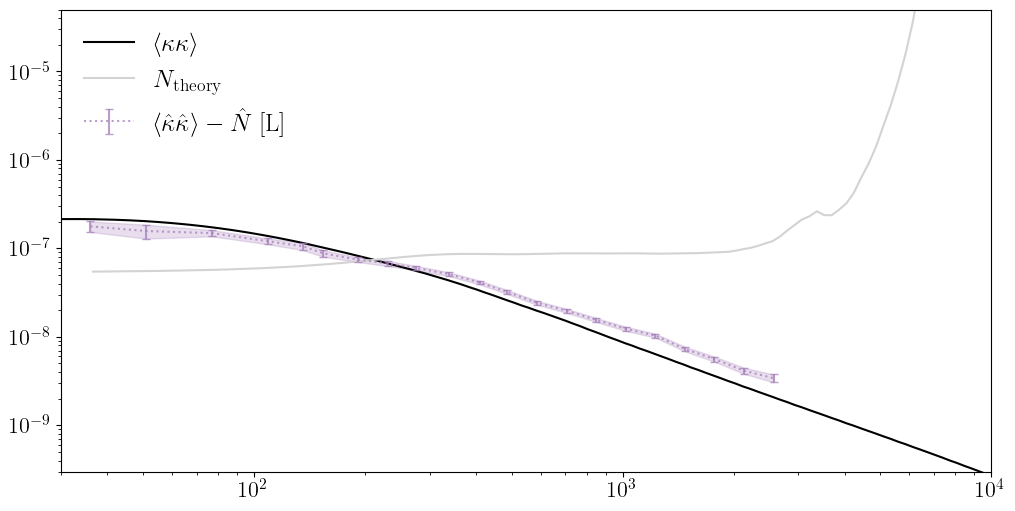

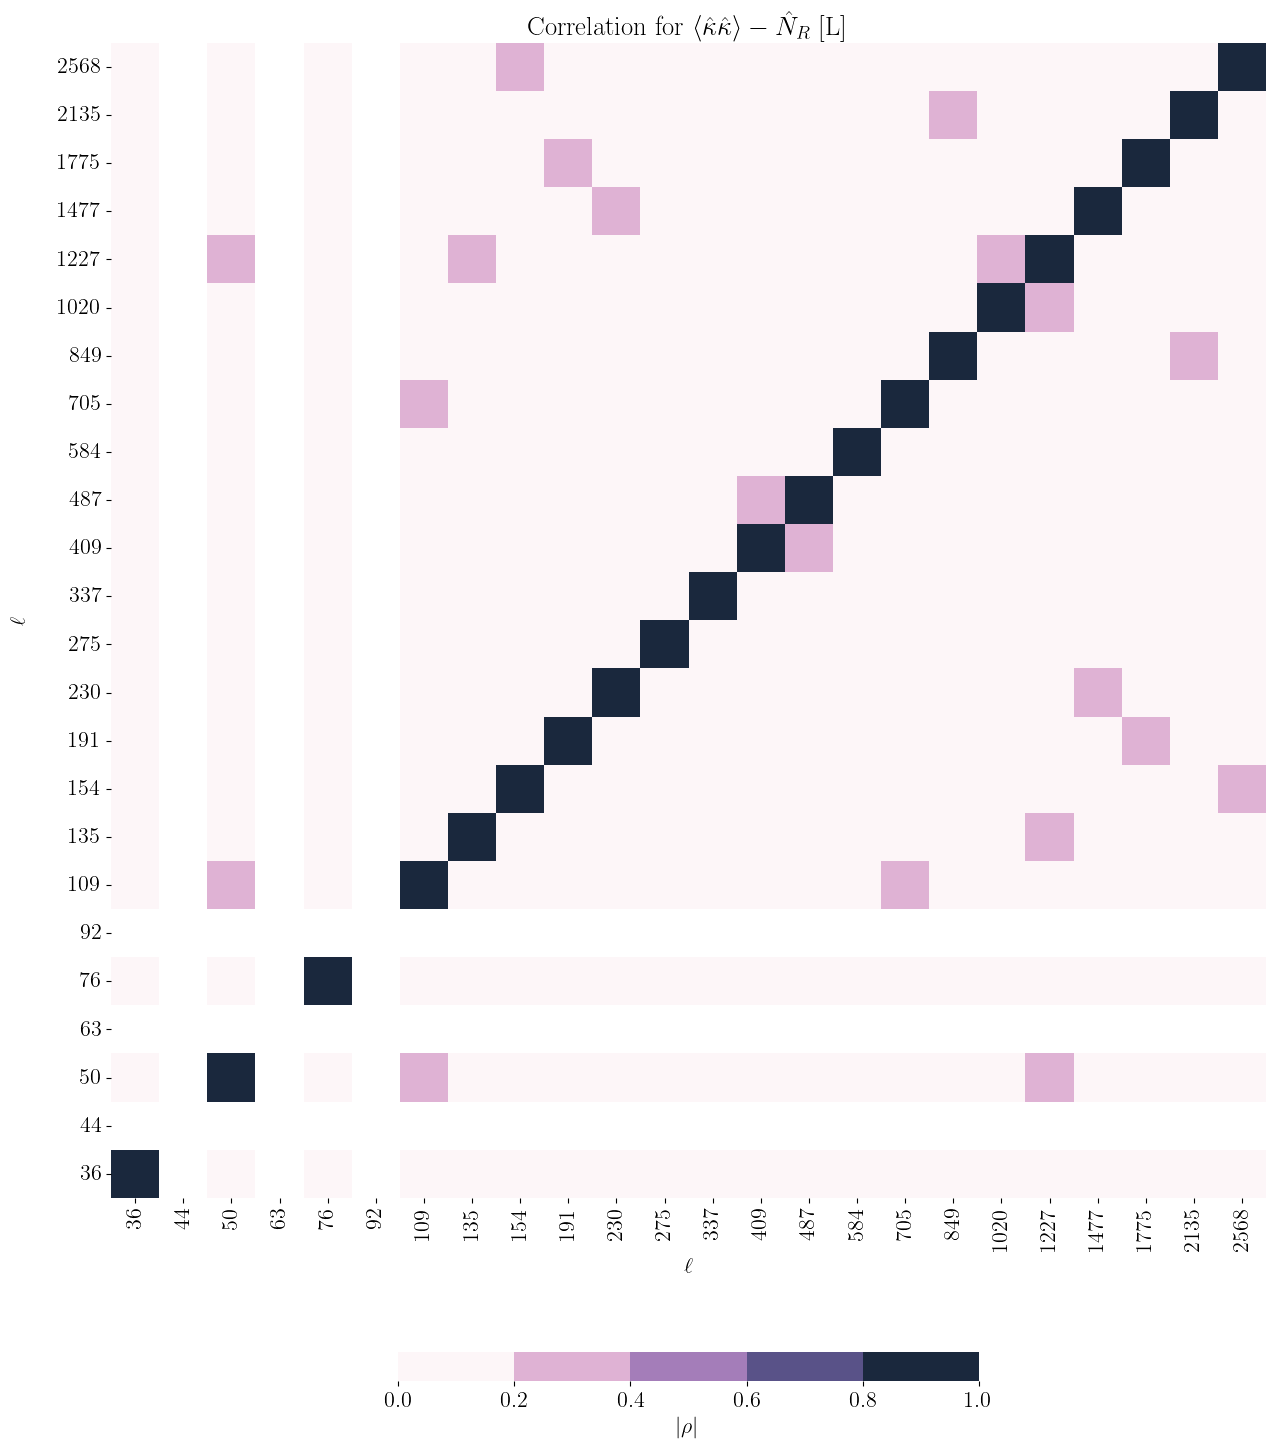

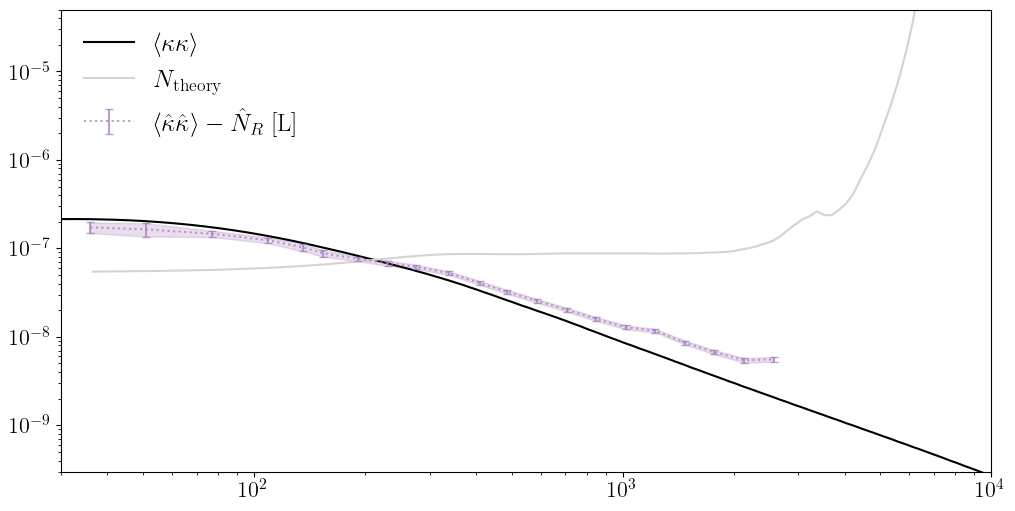

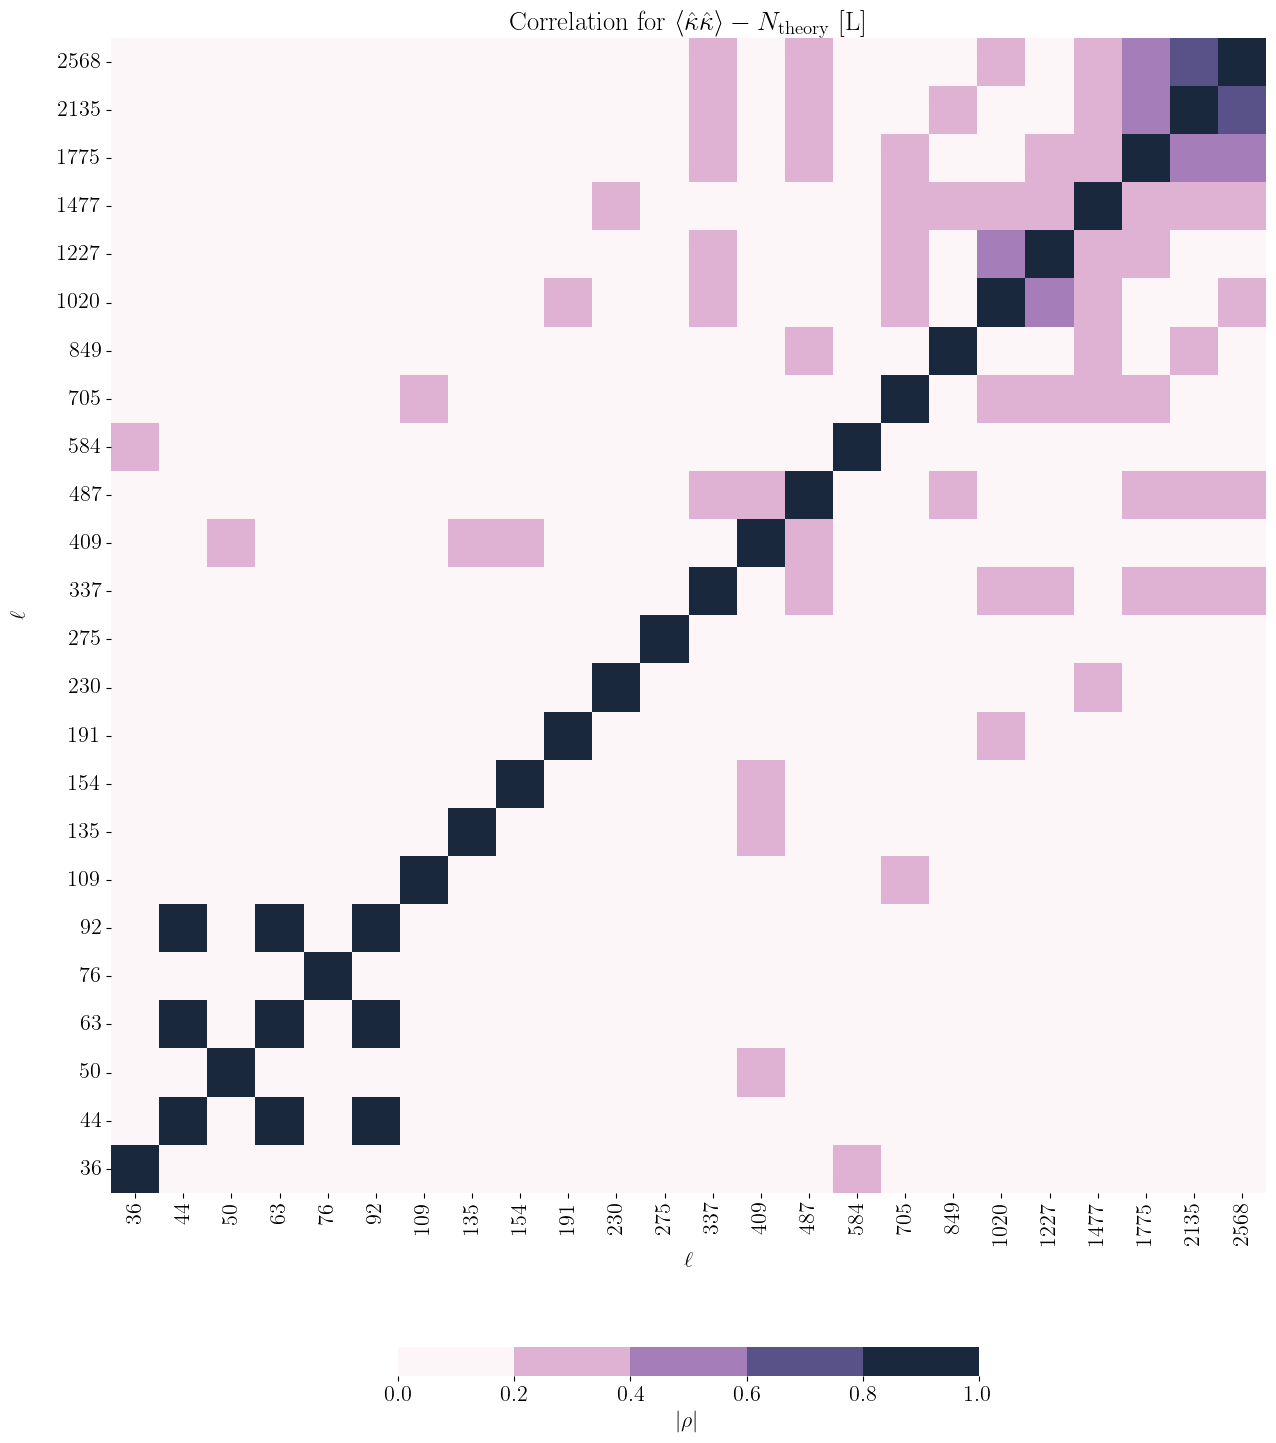

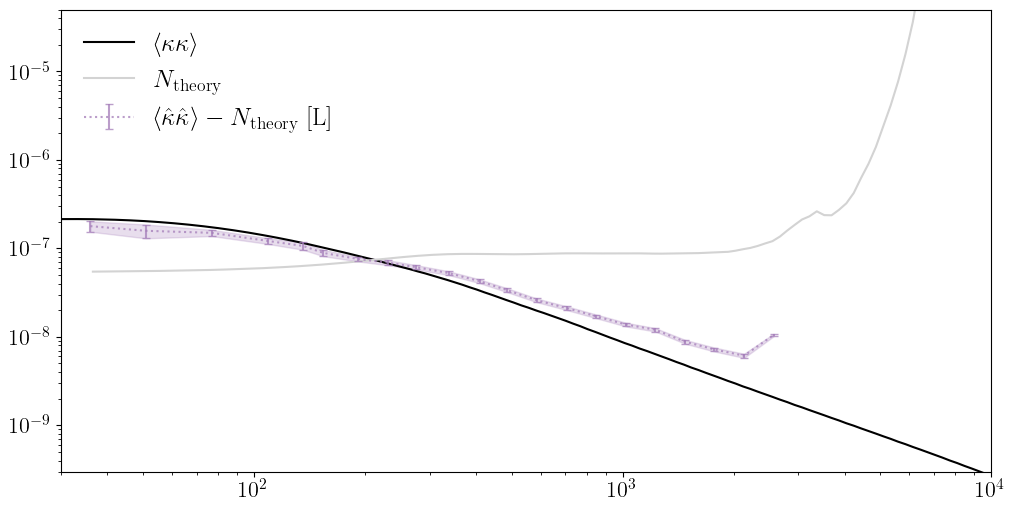

In [274]:
_, _ =corr_and_sub('kk0_1', 'Nhat0_1', cmap[0], r'$\left<\hat\kappa\hat\kappa\right>-\hat N$ [L]', 'kk_Nhat')
_, _ =corr_and_sub('kk0_1', 'kRkR0_1', cmap[0], r'$\left<\hat\kappa\hat\kappa\right>-\hat N_R$ [L]', 'kk_NRand')
_, _ =corr_and_sub('kk0_1', 'theory', cmap[0], 
             r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}$ [L]', 'kk_NTheory',
            theory=True)

100 (100, 3, 50)
100 (100, 3, 50)


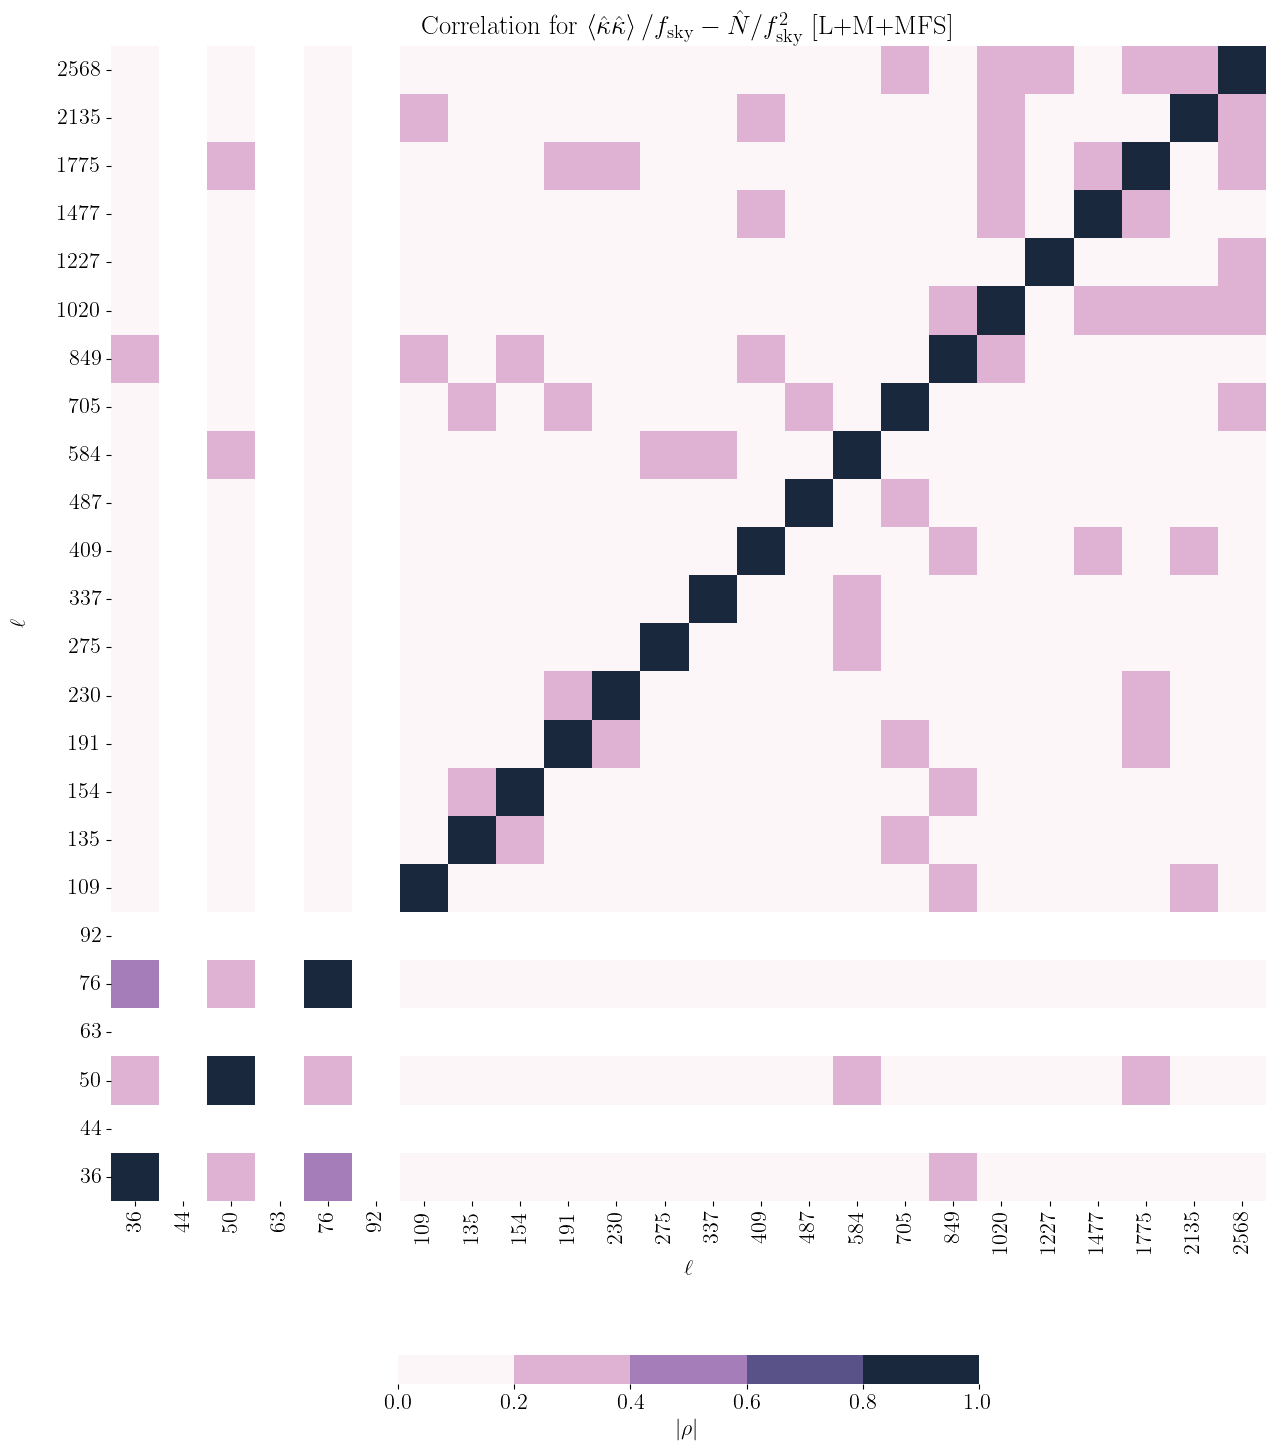

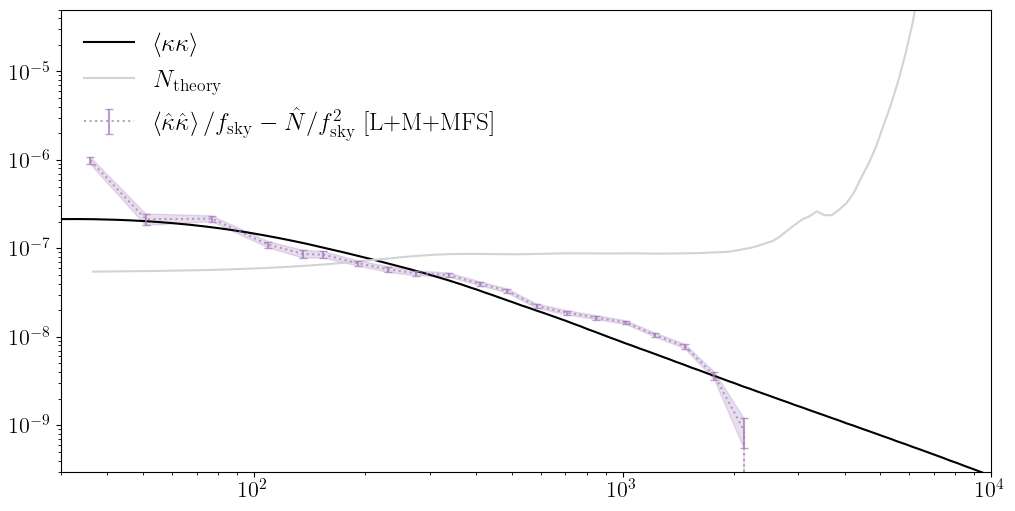

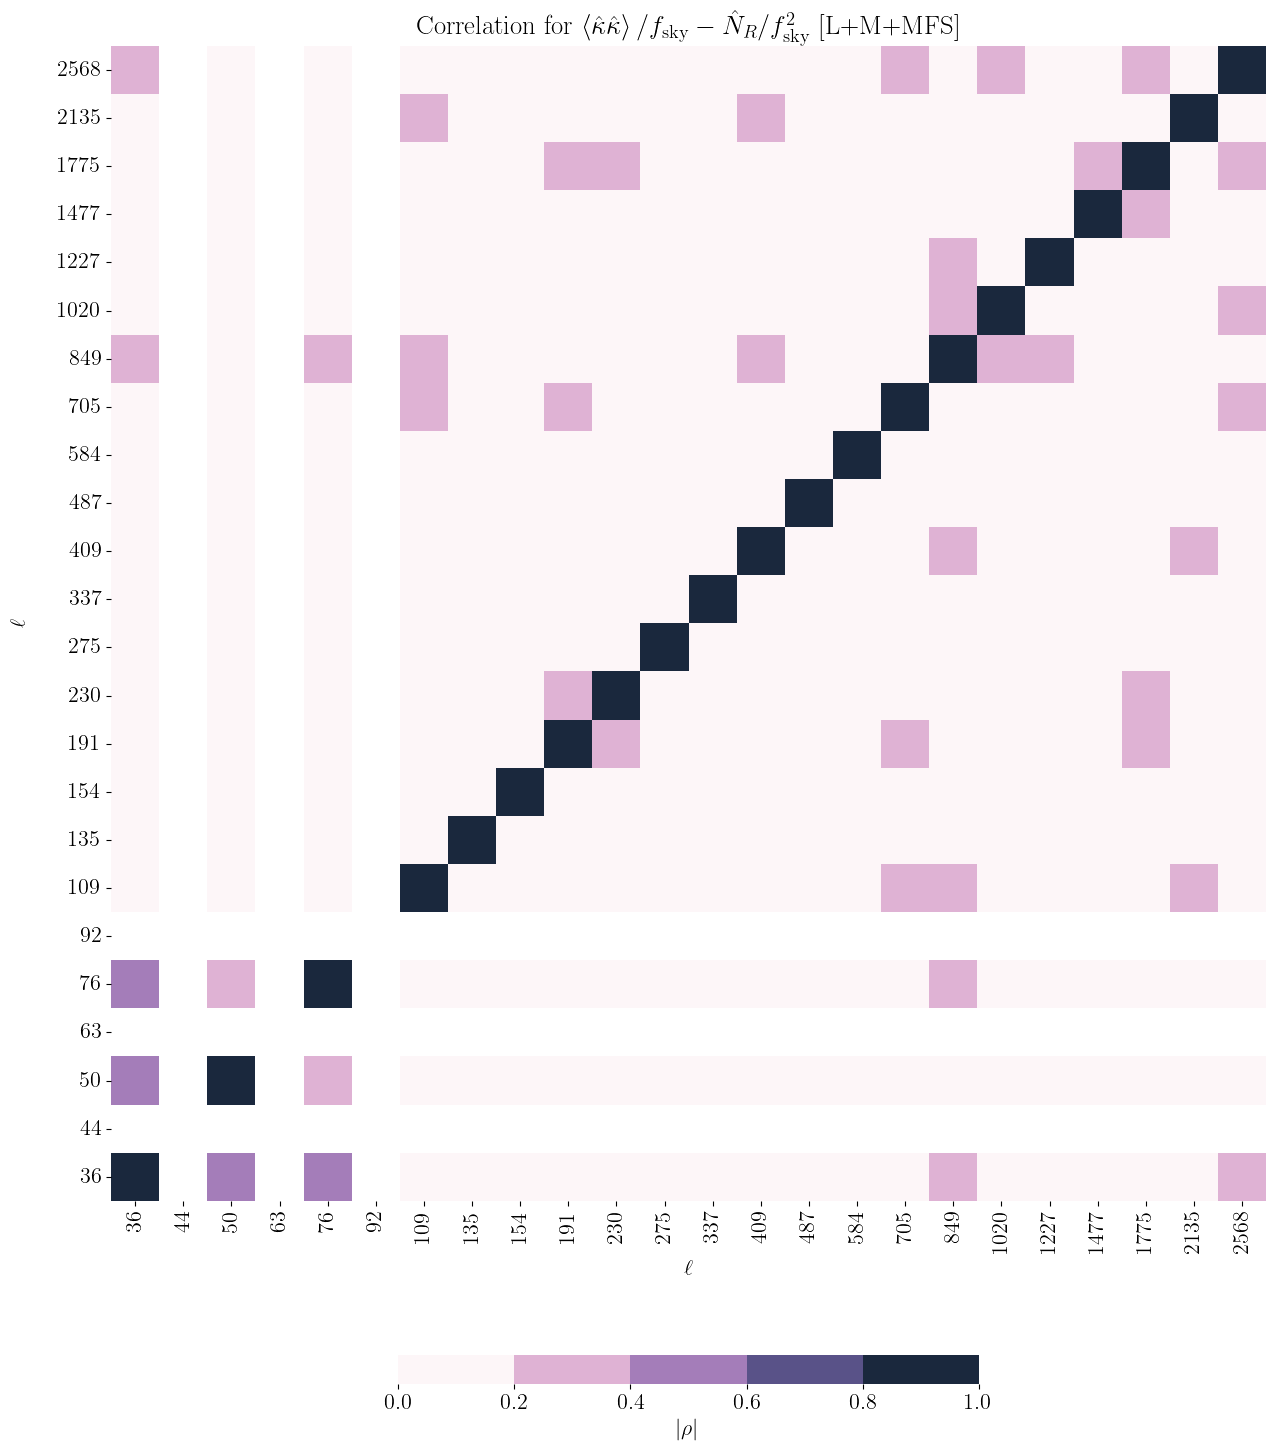

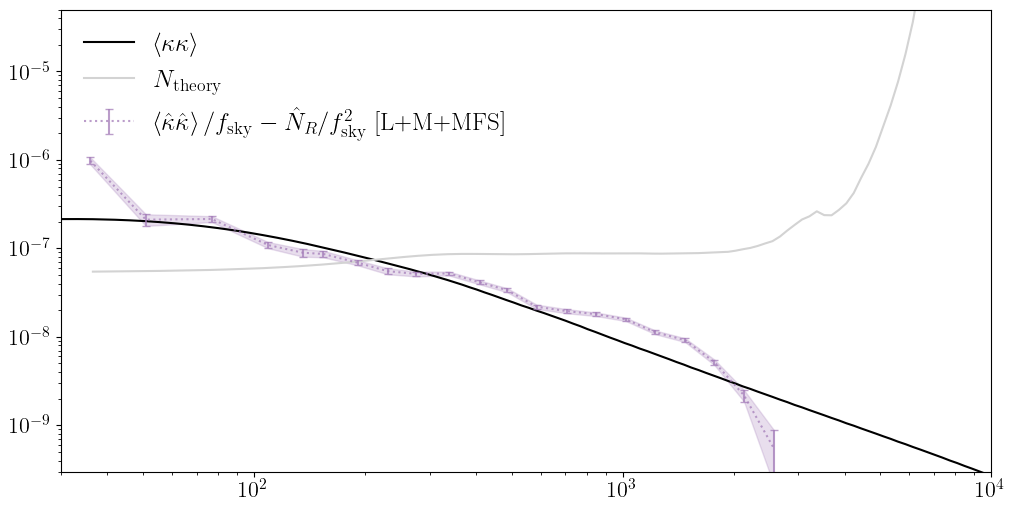

In [275]:
_, _ =corr_and_sub('kk1_1', 'Nhat1_1', cmap[0], r'$\left<\hat\kappa\hat\kappa\right>/f_{\rm sky}-\hat N/f_{\rm sky}^2$ [L+M+MFS]', 'kk_Nhat_masked')
_, _ =corr_and_sub('kk1_1', 'kRkR1_1', cmap[0], r'$\left<\hat\kappa\hat\kappa\right>/f_{\rm sky}-\hat N_R/f_{\rm sky}^2$ [L+M+MFS]', 'kk_NRand_masked')

In [276]:
f = open(kTkT_DATA_FNAME, 'rb') 
kTkT_data = pickle.load(f) 
f.close()

for key in kTkT_data:
    print(key, np.shape(kTkT_data[key]))

kT (100, 400, 400)
kTF (100, 400, 201)
kTkT (100, 3, 50)


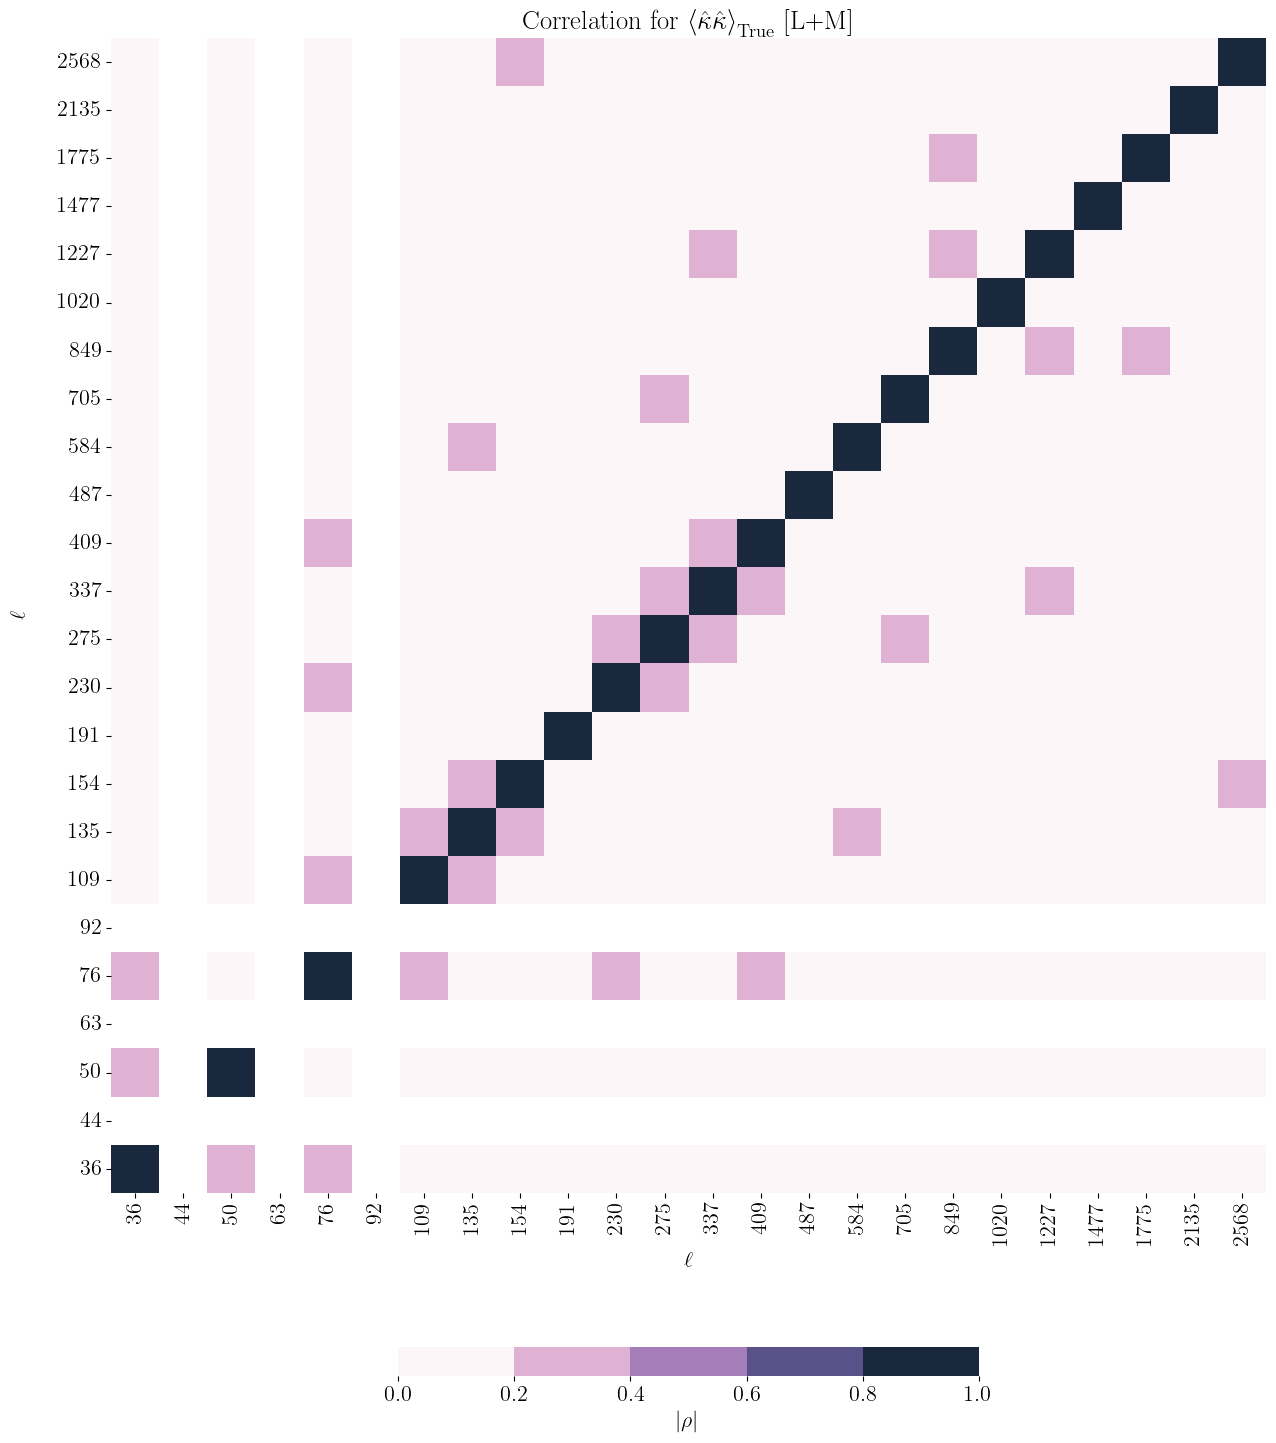

In [277]:
Cls_tmp = np.transpose(np.copy(kTkT_data['kTkT']), axes=[1,2,0])

corr_kTkT = np.array([[np.abs(np.corrcoef(Cls_tmp[1][i1], Cls_tmp[1][i2])[1,0])
                          for i1 in range(len(Cls_tmp[1]))]
                         for i2 in range(len(Cls_tmp[1]))])

corr(corr_kTkT, r'$\left<\hat\kappa\hat\kappa\right>_{\rm True}$ [L+M]', cmap[0], 'kTkT_masked')

plotting data
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


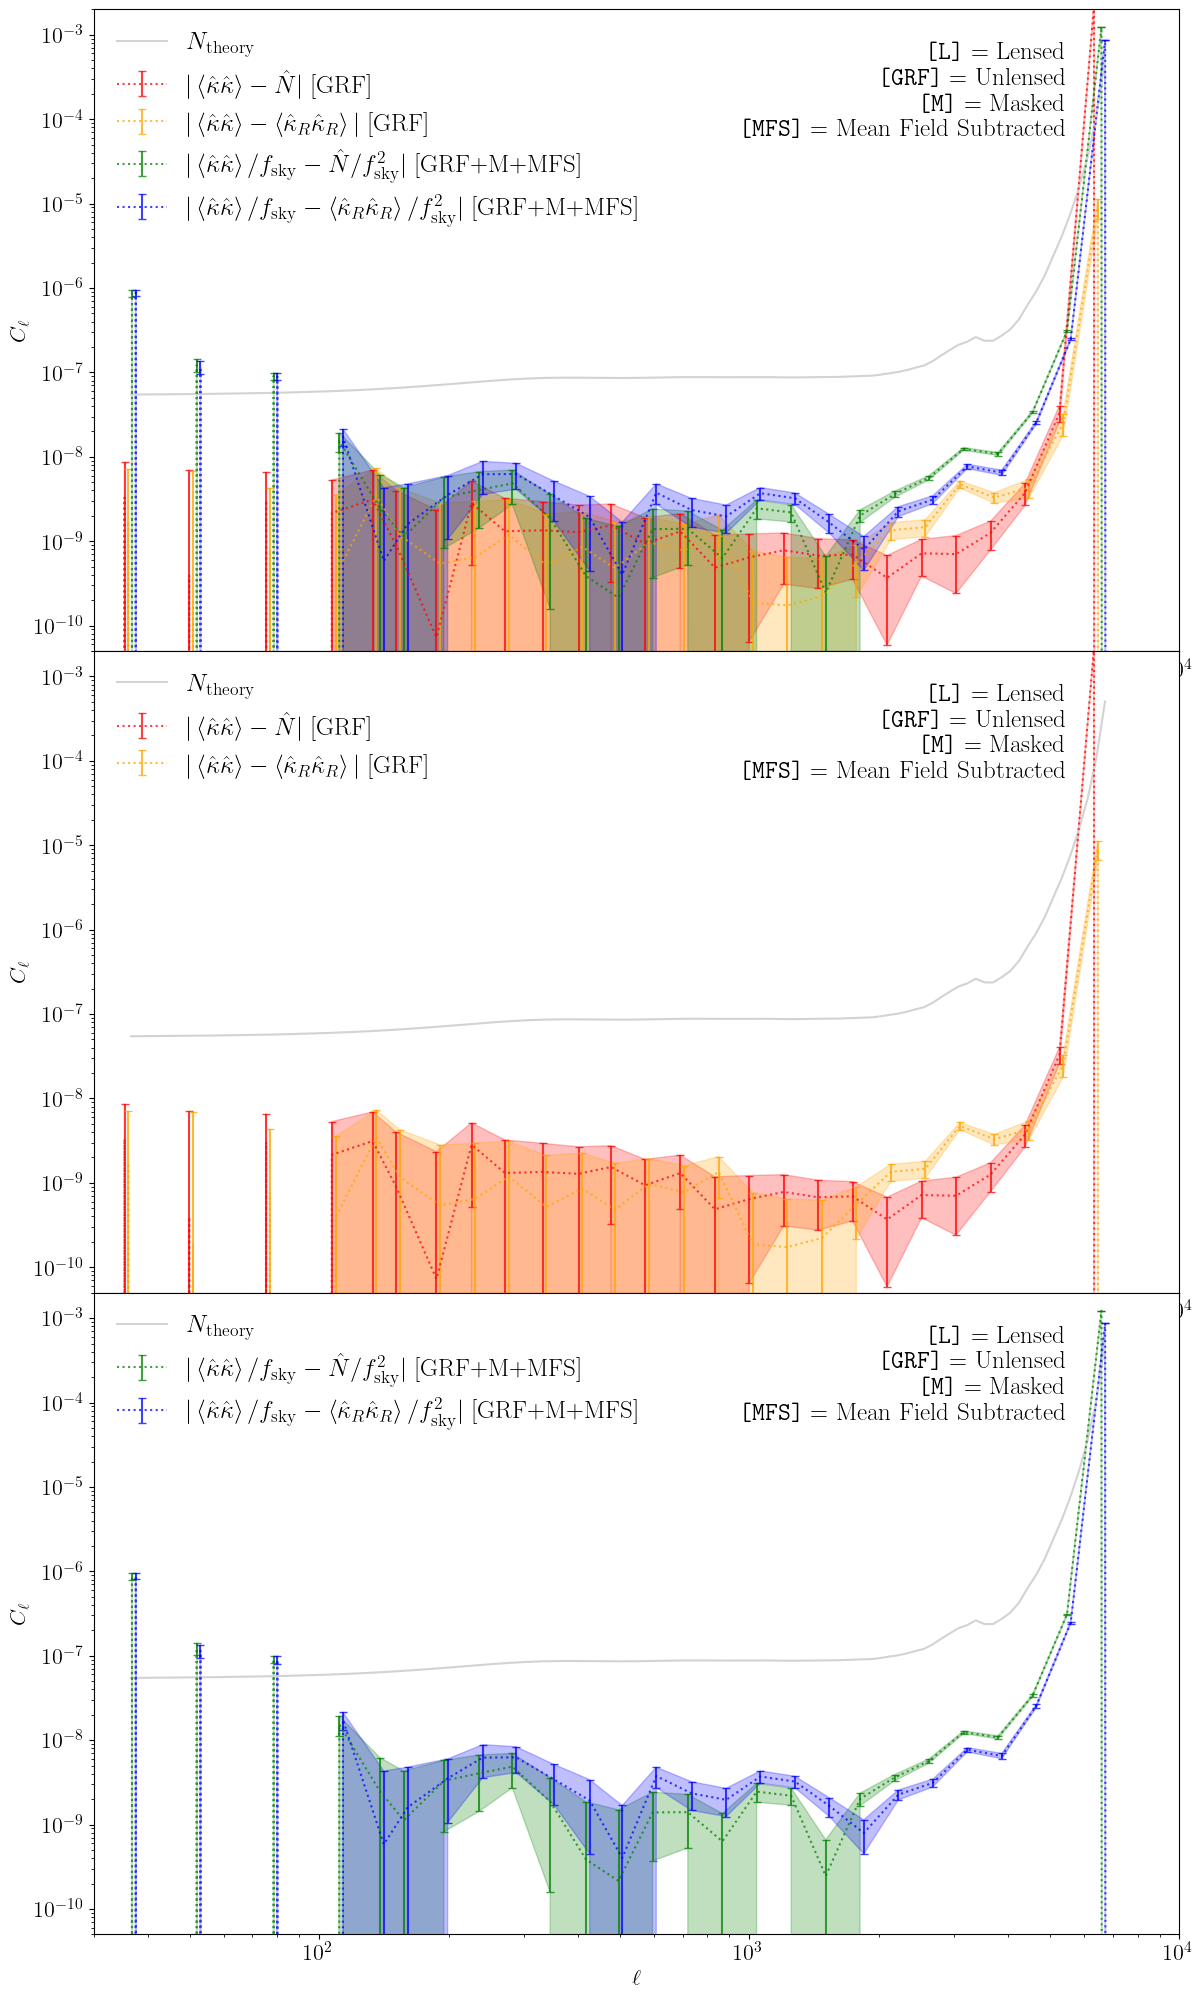

In [73]:
fig, axs = plt.subplots(nrows=3, figsize=(14,25), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
ell = baseMap.l.flatten()

theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    if('black'==sty):
        continue
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax in axs:
        ax.plot(L, ClExpected, sty, label=l)


c_keys = [
    'Nhat0_0',
    'kRkR0_0',
    'Nhat1_0',
    'kRkR1_0',
]

col = dict(zip(c_keys, [
    'r',
    'orange',
    'g',
    'b'
]))

labels = dict(zip(c_keys, [
    r'$|\left<\hat\kappa\hat\kappa\right> - \hat N|$ [GRF]',
    r'$|\left<\hat\kappa\hat\kappa\right> - \left<\hat\kappa_R\hat\kappa_R\right>|$ [GRF]',
    r'$|\left<\hat\kappa\hat\kappa\right>/f_{\rm sky} - \hat N/f_{\rm sky}^2|$ [GRF+M+MFS]',
    r'$|\left<\hat\kappa\hat\kappa\right>/f_{\rm sky} - \left<\hat\kappa_R\hat\kappa_R\right>/f_{\rm sky}^2|$ [GRF+M+MFS]',
]))
print('plotting data')

idxs = dict(zip(c_keys,
               [
                   [0,1],
                   [0,1],
                   [0,2],
                   [0,2]
               ]))
off = 0.02
offsets = dict(zip(c_keys, [-off,0,off,2*off]))
for key in c_keys:
    tmp_postfix = (key.split('_'))
    c_postfix = tmp_postfix[0][-1]+'_'+tmp_postfix[1]
    
    Cls_tmp = np.transpose(np.copy(data['kk'+c_postfix]), axes=[1,2,0])
    Cls_tmp[1] -= np.transpose(data[key], axes=[1,2,0])[1]
    Cls_tmp = np.transpose(Cls_tmp, axes=[2,0,1])
    
    lCen, Cl, sCl = combine_Cl(Cls_tmp)

    Ipos = np.where(Cl>=1e-30)

    for idx in idxs[key]:
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        ax = axs[idx]

        ax.errorbar(lCen+tmp, np.abs(Cl), 
                    yerr=sCl, c=col[key], 
                    alpha=.75, fmt=':', 
                    capsize=3, label=labels[key], capthick=1)

        tmp_data = {
           'x': lCen+tmp,
           'y1': [y - e for y, e in zip(np.abs(Cl), sCl)],
           'y2': [y + e for y, e in zip(np.abs(Cl), sCl)]}
        ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    

for ax in axs:
    l=ax.legend(frameon=False, loc='upper left')
    s = r'\texttt{[L]} = Lensed'
    s += '\n'
    s += r'\texttt{[GRF]} = Unlensed'
    s += '\n'
    s += r'\texttt{[M]} = Masked'
    s += '\n'
    s += r'\texttt{[MFS]} = Mean Field Subtracted'

    ax.set_xlim(30, 1e4)
    ax.set_ylim(5e-11, 2e-3)
    ax.text(.90, .95,
       s=s,
       transform=ax.transAxes,
       horizontalalignment='right',
       verticalalignment='top',
      fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$C_\ell$')
plt.savefig(
'figures/Cl_residual_unlensed.pdf',
    bbox_inches='tight'
)
plt.savefig(
'figures/Cl_residual_unlensed.png',
    bbox_inches='tight'
)

plotting data
100 (100, 3, 50)
100 (100, 3, 50)


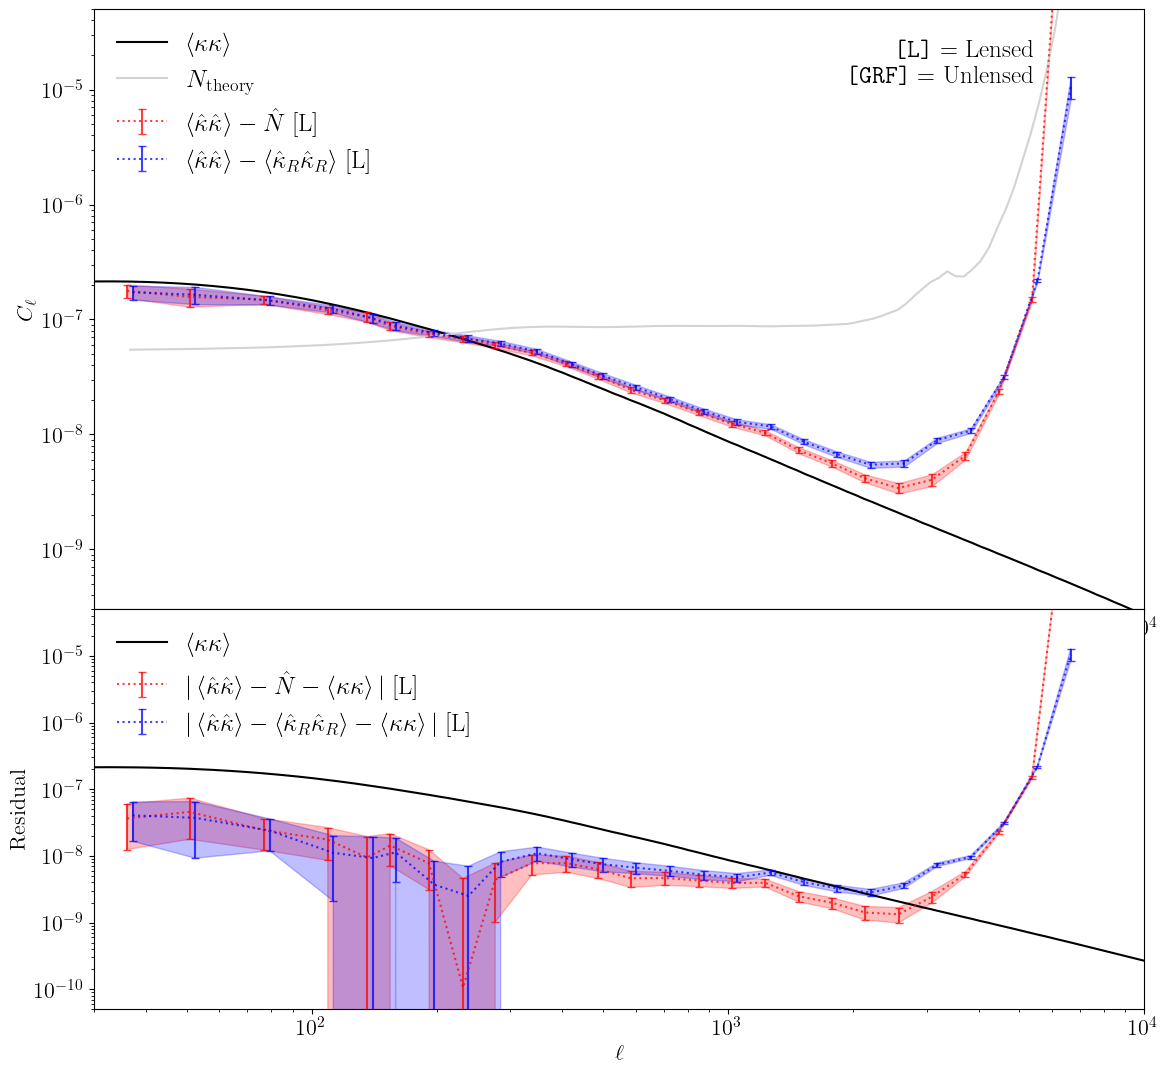

In [76]:
fig1 = plt.figure(figsize =(14, 10))

axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]

# fig.subplots_adjust(wspace=0, hspace=0)
ell = baseMap.l.flatten()

theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax_idx in range(len(axs)):
        ax = axs[ax_idx]
        if(ax_idx==1 and sty=='lightgrey'):
            continue
        ax.plot(L, ClExpected, sty, label=l)


c_keys = [
    'Nhat0_1',
    'kRkR0_1',
]

col = dict(zip(c_keys, [
    'r',
    'b',
]))

labels = dict(zip(c_keys, [
    r'$\left<\hat\kappa\hat\kappa\right> - \hat N$ [L]',
    r'$\left<\hat\kappa\hat\kappa\right> - \left<\hat\kappa_R\hat\kappa_R\right>$ [L]',
]))

aux_labels = dict(zip(c_keys, [
    r'$|\left<\hat\kappa\hat\kappa\right> - \hat N - \left<\kappa\kappa\right>|$ [L]',
    r'$|\left<\hat\kappa\hat\kappa\right> - \left<\hat\kappa_R\hat\kappa_R\right> - \left<\kappa\kappa\right>|$ [L]',
]))
print('plotting data')

idxs = dict(zip(c_keys,
               [
                   [0],
                   [0],
               ]))
off=0.03
offsets = dict(zip(c_keys,[0, off]))

for key in c_keys:
    tmp_postfix = (key.split('_'))
    c_postfix = tmp_postfix[0][-1]+'_'+tmp_postfix[1]
    
    Cls_tmp = np.transpose(np.copy(data['kk'+c_postfix]), axes=[1,2,0])
    Cls_tmp[1] -= np.transpose(data[key], axes=[1,2,0])[1]
    Cls_tmp = np.transpose(Cls_tmp, axes=[2,0,1])
    
    lCen, Cl, sCl = combine_Cl(Cls_tmp)

    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]

    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    lCen = lCen[Ipos]
    Cl = Cl[Ipos]
    sCl = sCl[Ipos]

    
    ax = axs[0]

    ax.errorbar(lCen, (Cl), 
                yerr=sCl, c=col[key], 
                alpha=.75, fmt=':', 
                capsize=3, label=labels[key], capthick=1)

    tmp_data = {
       'x': lCen,
       'y1': [y - e for y, e in zip((Cl), sCl)],
       'y2': [y + e for y, e in zip((Cl), sCl)]}
    ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    
    
    Cl_res = Cl - np.array(list(map(p2d_cmblens.fPinterp, lCen)))
    ax = axs[1]

    ax.errorbar(lCen, np.abs(Cl_res), 
                yerr=sCl, c=col[key], 
                alpha=.75, fmt=':', 
                capsize=3, label=aux_labels[key], capthick=1)

    tmp_data = {
       'x': lCen,
       'y1': [y - e for y, e in zip(np.abs(Cl_res), sCl)],
       'y2': [y + e for y, e in zip(np.abs(Cl_res), sCl)]}
    ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    
    ax.set_ylabel(r'Residual')

    
axs[1].axhline(0, linewidth=1, linestyle="--", color="black")
axylims = [(3e-10, .5e-4), (.5e-10,.5e-4)]
for ax_idx in range(len(axs)):
    ax = axs[ax_idx]
    l=ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(30,1e4)

    ax.set_ylim(axylims[ax_idx])
    if(ax_idx==1):
        continue

    s = r'\texttt{[L]} = Lensed'
    s += '\n'
    s += r'\texttt{[GRF]} = Unlensed'
    ax.text(.90, .95,
       s=s,
       transform=ax.transAxes,
       horizontalalignment='right',
       verticalalignment='top',
      fontsize=18)
    ax.set_ylabel(r'$C_\ell$')
plt.savefig(
'figures/Cl_lensed.pdf',
    bbox_inches='tight'
)
plt.savefig(
'figures/Cl_lensed.png',
    bbox_inches='tight'
)

plotting data
100 (100, 3, 50)
[  36.           50.91168825   76.85625554  109.22385956  135.88562624
  154.31849171  191.27014862  230.84931941  275.9139776   337.76701993
  409.2146317   487.12178369  584.54181879  705.78075154  849.56765378
 1020.71624956 1227.84902286 1477.25960959 1775.43810787 2135.54713152
 6464.51210164]
100 (100, 3, 50)
[  36.           50.91168825   76.85625554  109.22385956  135.88562624
  154.31849171  191.27014862  230.84931941  275.9139776   337.76701993
  409.2146317   487.12178369  584.54181879  705.78075154  849.56765378
 1020.71624956 1227.84902286 1477.25960959 1775.43810787 2135.54713152
 2568.78449534]


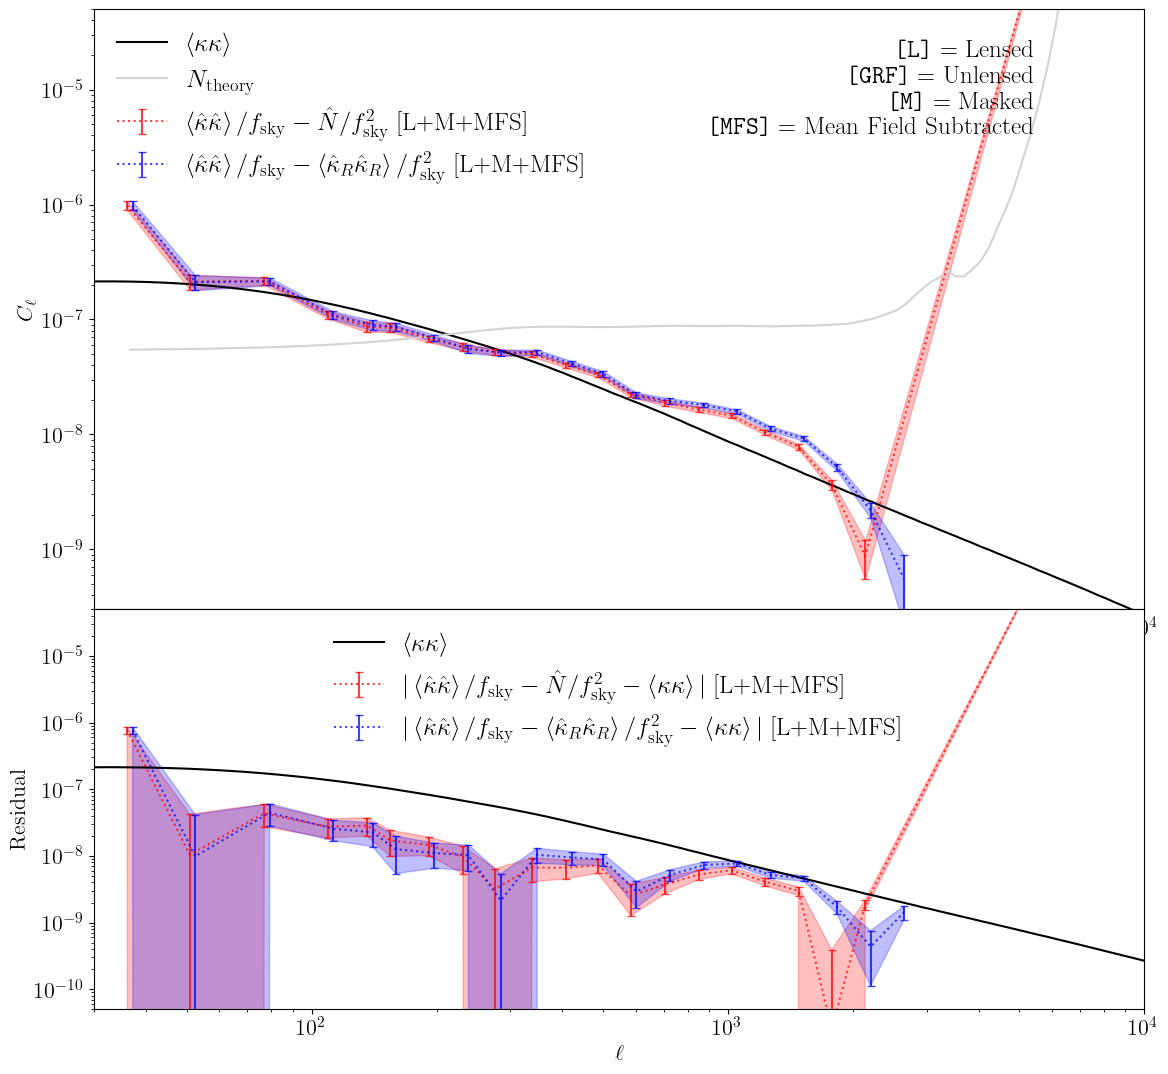

In [269]:
fig1 = plt.figure(figsize =(14, 10))

axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]

# fig.subplots_adjust(wspace=0, hspace=0)
ell = baseMap.l.flatten()

theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax_idx in range(len(axs)):
        ax = axs[ax_idx]
        if(ax_idx==1 and sty=='lightgrey'):
            continue
        ax.plot(L, ClExpected, sty, label=l)


c_keys = [
    'Nhat1_1',
    'kRkR1_1',
]
off=0.03
offsets = dict(zip(c_keys,[0, off]))
col = dict(zip(c_keys, [
    'r',
    'b',
]))

labels = dict(zip(c_keys, [
    r'$\left<\hat\kappa\hat\kappa\right>/f_{\rm sky} - \hat N/f_{\rm sky}^2$ [L+M+MFS]',
    r'$\left<\hat\kappa\hat\kappa\right>/f_{\rm sky} - \left<\hat\kappa_R\hat\kappa_R\right>/f_{\rm sky}^2$ [L+M+MFS]',
]))

aux_labels = dict(zip(c_keys, [
    r'$|\left<\hat\kappa\hat\kappa\right>/f_{\rm sky} - \hat N/f_{\rm sky}^2 - \left<\kappa\kappa\right>|$ [L+M+MFS]',
    r'$|\left<\hat\kappa\hat\kappa\right>/f_{\rm sky} - \left<\hat\kappa_R\hat\kappa_R\right>/f_{\rm sky}^2 - \left<\kappa\kappa\right>|$ [L+M+MFS]',
]))
print('plotting data')

idxs = dict(zip(c_keys,
               [
                   [0],
                   [0],
               ]))

for key in c_keys:
    tmp_postfix = (key.split('_'))
    c_postfix = tmp_postfix[0][-1]+'_'+tmp_postfix[1]
    
    Cls_tmp = np.transpose(np.copy(data['kk'+c_postfix]), axes=[1,2,0])
    Cls_tmp[1] -= np.transpose(data[key], axes=[1,2,0])[1]
    Cls_tmp = np.transpose(Cls_tmp, axes=[2,0,1])
    
    lCen, Cl, sCl = combine_Cl(Cls_tmp)

    Ipos = np.where(Cl>=1e-30)
    
    lCen = lCen[Ipos]
    Cl = Cl[Ipos]
    sCl = sCl[Ipos]
    print(lCen)
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]

    lCen += tmp
    
    ax = axs[0]

    ax.errorbar(lCen, (Cl), 
                yerr=sCl, c=col[key], 
                alpha=.75, fmt=':', 
                capsize=3, label=labels[key], capthick=1)

    tmp_data = {
       'x': lCen,
       'y1': [y - e for y, e in zip((Cl), sCl)],
       'y2': [y + e for y, e in zip((Cl), sCl)]}
    ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    
    
    Cl_res = Cl - np.array(list(map(p2d_cmblens.fPinterp, lCen)))
    ax = axs[1]
    

    ax.errorbar(lCen, np.abs(Cl_res), 
                yerr=sCl, c=col[key], 
                alpha=.75, fmt=':', 
                capsize=3, label=aux_labels[key], capthick=1)

    tmp_data = {
       'x': lCen,
       'y1': [y - e for y, e in zip(np.abs(Cl_res), sCl)],
       'y2': [y + e for y, e in zip(np.abs(Cl_res), sCl)]}
    ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    
    ax.set_ylabel(r'Residual')

    
axs[1].axhline(0, linewidth=1, linestyle="--", color="black")

axylims = [(3e-10, .5e-4), (.5e-10,.5e-4)]


for ax_idx in range(len(axs)):
    ax = axs[ax_idx]
    l=ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(30,1e4)
    ax.set_ylim(axylims[ax_idx])

    if(ax_idx==1):
        continue

    s = r'\texttt{[L]} = Lensed'
    s += '\n'
    s += r'\texttt{[GRF]} = Unlensed'
    s += '\n'
    s += r'\texttt{[M]} = Masked'
    s += '\n'
    s += r'\texttt{[MFS]} = Mean Field Subtracted'
    ax.text(.90, .95,
       s=s,
       transform=ax.transAxes,
       horizontalalignment='right',
       verticalalignment='top',
      fontsize=18)
    ax.set_ylabel(r'$C_\ell$')
plt.savefig(
'figures/Cl_lensed_masked.pdf',
    bbox_inches='tight'
)
plt.savefig(
'figures/Cl_lensed_masked.png',
    bbox_inches='tight'
)

In [348]:
import matplotlib as mpl

def corr2(corr_nhat1, corr_nhat2, label, label2, cmap, cmap2, filename_base, ll = ['%d'%l for l in data['kk0_0'][0][0]]):
    mpl.use("pdf")
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 26
    plt.rcParams['text.latex.preamble'] = r'\usepackage{xcolor}'
    plt.rcParams['text.latex.preamble'] +='\n'
    plt.rcParams['text.latex.preamble'] += r'\definecolor{c1}{rgb}{%.1f,%.1f,%.1f}'%(cmap[3][0],cmap[3][1],cmap[3][2])
    plt.rcParams['text.latex.preamble'] +='\n'
    plt.rcParams['text.latex.preamble'] +=r'\definecolor{c2}{rgb}{%.1f,%.1f,%.1f}'%(cmap2[3][0],cmap2[3][1],cmap2[3][2])

    
    corr_nhat = np.copy(corr_nhat1)
    sze = len(corr_nhat1)
    mask = np.array([[0 for _ in range(sze)] for _ in range(sze)])
    for i in range(sze-1):
        for j in range(sze-1-i):
            corr_nhat[i][sze-j-1] = corr_nhat2[i][sze-j-1]
            mask[i][sze-j-1] = 1
    plt.figure(figsize=(25,20))
    print(np.shape(corr_nhat))
    print(np.shape(mask))
    
    ax = sns.heatmap(corr_nhat,  cmap=cmap, cbar=True, vmin=0, vmax=1, square=True,
                    cbar_kws={ 'ticks':[],
                              "orientation": "horizontal", 'pad':-0.17, 'shrink':0.3})
    
    sns.heatmap(corr_nhat, mask=mask, cmap=cmap2, cbar=True, ax=ax, vmin=0, vmax=1,square=True,label=label,
           cbar_kws={'label': r"$|\rho|$","orientation": "horizontal", 'pad':0.1,  'shrink':0.3})
    

    ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
    ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
    plt.xlabel(r'$\ell$'+'\n')

    ax.legend(frameon=False)

    ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
    ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
    plt.ylabel(r'$\ell$'+'\n')

    plt.title(r'Correlation for \color{c1}{%s} and \textcolor{c2}{%s}'%(label, label2))
    plt.xlim(19, 43)
    plt.ylim(19, 43)

    plt.savefig('figures/corr_%s.pdf'%(filename_base), bbox_inches='tight')#, use='pgf')
#     plt.savefig('figures/corr_%s.png'%(filename_base), bbox_inches='tight')


In [349]:
Cls_tmp = np.transpose(np.copy(data['kk1_1']), axes=[1,2,0])
ls = data['kk1_1'][0][0]
ll = ['%d'%l for l in ls]

Cls_tmp[1] -= np.transpose(data['Nhat1_1'], axes=[1,2,0])[1]

corr_nhat = np.array([[np.abs(np.corrcoef(Cls_tmp[1][i1], Cls_tmp[1][i2])[1,0])
                      for i1 in range(len(Cls_tmp[1]))]
                     for i2 in range(len(Cls_tmp[1]))])

In [350]:
corr2(corr_nhat, corr_kTkT, 
      label= r'$\left<\hat\kappa\hat\kappa\right>/f_{\rm sky}-\hat N/f_{\rm sky}^2$ [L+M+MFS]',
     label2=r'$\left<\hat\kappa\hat\kappa\right>_{\rm True}$ [L+M]', cmap=cmap[0], cmap2=cmap[1],
     filename_base='Nhatsub_vs_kTkT')

(50, 50)
(50, 50)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
